In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from importlib.util import find_spec
if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('..')

In [2]:
from qml_hep_lhc.data import MNIST
import argparse

2022-08-07 08:34:46.925349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-07 08:34:46.925383: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
args = argparse.Namespace()
args.center_crop = 0.7
args.resize = [8,8]
args.standardize = 1
args.binary_data = [0,1]
args.optimizer = 'Ranger'
args.labels_to_categorical = 1
args.processed = 1
args.percent_samples = 0.1
args.batch_size = 4

data = MNIST(args)
data.prepare_data()
data.setup()
print(data)

Binarizing data...
Binarizing data...
Center cropping...
Center cropping...
Resizing data...
Resizing data...
Standardizing data...
Converting labels to categorical...
Converting labels to categorical...

Dataset :MNIST
╒════════╤═══════════════╤═══════════════╤═══════════════╤═══════════╕
│ Data   │ Train size    │ Val size      │ Test size     │ Dims      │
╞════════╪═══════════════╪═══════════════╪═══════════════╪═══════════╡
│ X      │ (48, 8, 8, 1) │ (12, 8, 8, 1) │ (20, 8, 8, 1) │ (8, 8, 1) │
├────────┼───────────────┼───────────────┼───────────────┼───────────┤
│ y      │ (48, 2)       │ (12, 2)       │ (20, 2)       │ (2,)      │
╘════════╧═══════════════╧═══════════════╧═══════════════╧═══════════╛

╒══════════════╤═══════╤═══════╤════════╤═══════╤══════════════════════════╕
│ Type         │   Min │   Max │   Mean │   Std │ Samples for each class   │
╞══════════════╪═══════╪═══════╪════════╪═══════╪══════════════════════════╡
│ Train Images │ -1.58 │  7.68 │  -0.01 │  1    │ [

2022-08-07 08:34:49.861089: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-07 08:34:49.861125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bhagvada): /proc/driver/nvidia/version does not exist
2022-08-07 08:34:49.861823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

layer_1 = tf.keras.layers.Dense(2)
layer_2 = tf.keras.layers.Dense(2, activation="softmax")

model = tf.keras.Sequential([layer_1, layer_2])
model.compile(loss="mae")

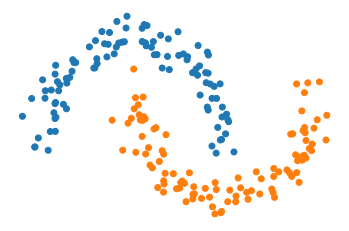

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [25]:
import pennylane as qml

n_qubits = 2
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights, bias):
    inputs = inputs + bias
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


In [26]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits),
                "bias": (n_qubits,)}

In [27]:
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [28]:
# rlayer = tf.keras.layers.Reshape((64,), input_shape=(8,8,1))
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy", tf.keras.metrics.AUC()])

In [37]:
fitting = model.fit(X,y_hot,
                    batch_size=4,
                   epochs=1,
                   shuffle=True,
                   workers=2)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul]